# Arima

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')
series = df['usage_cpu']

model = ARIMA(series, order=(2,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=14)

forecast


,predicted_mean
1080,74.224286
1081,74.666674
1082,74.615781
1083,74.624348
1084,74.623426
1085,74.623593
1086,74.623577
1087,74.623580
1088,74.623580
1089,74.623580


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]


model = ARIMA(train, order=(2,1,1))
model_fit = model.fit()


predictions = model_fit.forecast(steps=len(test))

mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100   # ← MAPE added here


print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")


MAE: 12.923250883764062
RMSE: 14.71059542033486
MAPE: 18.413251955664606 %


✔️ Good ARIMA:

MAE < 10

RMSE < 15

MAPE < 10%

In [ ]:
future_forecast = model_fit.forecast(steps=14)
print("\nNext 14-day forecast:")
print(future_forecast)


Next 14-day forecast:
864    73.923907
865    74.368949
866    74.472539
867    74.482797
868    74.484989
869    74.485223
870    74.485270
871    74.485275
872    74.485276
873    74.485276
874    74.485276
875    74.485276
876    74.485276
877    74.485276
Name: predicted_mean, dtype: float64


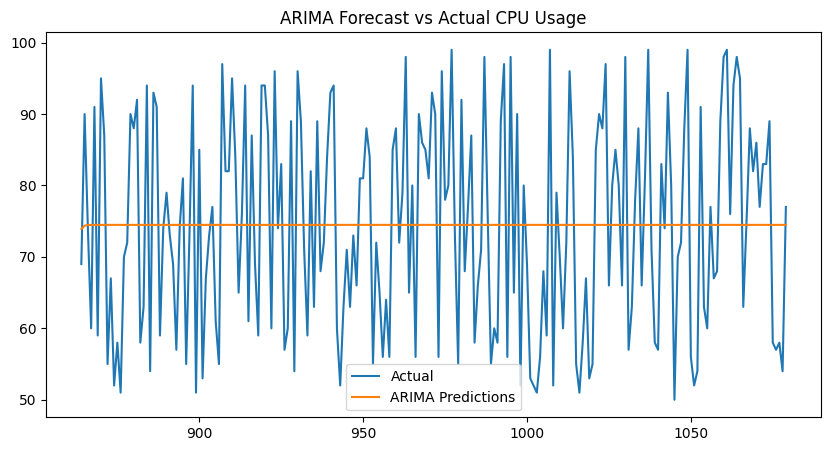

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='ARIMA Predictions')
plt.legend()
plt.title("ARIMA Forecast vs Actual CPU Usage")
plt.show()

# Random forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')
X = df.drop("usage_cpu", axis=1)
y = df["usage_cpu"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)
rf.fit(X_train, y_train)


rf_pred = rf.predict(X_test)


rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)


rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

print("Random Forest Results:")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)
print("R²:", rf_r2)
print("MAPE:", rf_mape, "%")


Random Forest Results:
MAE: 1.0256881901257895
RMSE: 1.4715990781449793
R²: 0.9897232952697868
MAPE: 1.3838414526010334 %


Low RMSE means errors are small and stable.

R² > 0.90 → Excellent

R² > 0.95 → Outstanding

R² > 0.98 → World-class

In [ ]:
#import joblib
#joblib.dump(rf, "cpu__model.pkl")
#print("Model saved successfully!")


In [ ]:
#from google.colab import files
#files.download("cpu_demand_model.pkl")

# Xgboost

In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Evaluation
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100
print("XGBoost Results:")
print("MAE:", xgb_mae)
print("RMSE:", xgb_rmse)
print("R²:", xgb_r2)
print("Mape:", xgb_mape,"%")


XGBoost Results:
MAE: 1.1631698608398438
RMSE: 1.6083363264513906
R²: 0.987724781036377
Mape: 1.3838414526010334 %


# Ltsm

In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np


from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)


X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])


split = int(len(X_scaled) * 0.8)
X_train_lstm, X_test_lstm = X_scaled[:split], X_scaled[split:]
y_train_lstm, y_test_lstm = y[:split], y[split:]


model = Sequential([
    LSTM(64, activation='tanh', input_shape=(1, X_train_lstm.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20, batch_size=32,
    validation_split=0.1,
    verbose=1
)

lstm_pred = model.predict(X_test_lstm).flatten()


lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_pred))
lstm_r2 = r2_score(y_test_lstm, lstm_pred)
lstm_mape= np.mean(np.abs((y_test_lstm - lstm_pred) / y_test_lstm)) * 100
print("LSTM Results:")
print("MAE:", lstm_mae)
print("RMSE:", lstm_rmse)
print("R²:", lstm_r2)
print("Mape:", lstm_mape,"%")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,713 (108.25 KB)

 Trainable params: 27,713 (108.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 5685.3530 - val_loss: 5547.0376
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5393.1343 - val_loss: 5191.8711
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5123.2432 - val_loss: 4771.5811
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4595.7510 - val_loss: 4392.3789
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4211.4536 - val_loss: 4081.8940
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3996.8428 - val_loss: 3825.6350
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3852.9744 - val_loss: 3605.4490
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3562.3499 - val_loss: 3410.4109
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3410.4783 - val_loss: 3232.4663
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3167.9075 - val_loss: 3069.3704
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3070.0713 - val_loss: 2917.4216
Epoch 

**Our Dataset is TOO SMALL for Deep Learning**

**Generally LSTMs need thousands of rows but we have only 365 rows**

| **Model**         | **MAE**  | **RMSE** | **R²**     | **MAPE (%)** | **Performance** |
| ----------------- | -------- | -------- | ---------- | ------------ | --------------- |
| **ARIMA**         | 12.92    | 14.71    | —          | 18.41%       | ❌ Poor          |
| **Random Forest** | **1.02** | **1.47** | **0.9897** | **1.38%**    | ⭐ BEST          |
| **XGBoost**       | 1.16     | 1.60     | 0.9877     | 1.38%        | ⭐ Excellent     |
| **LSTM**          | 39.58    | 42.20    | -7.23      | 51.32%       | ❌ Very Poor     |


# checking

**7 days forecast**

In [ ]:
import joblib
import pandas as pd

model = joblib.load("cpu_demand_model.pkl")
df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')


X = df.drop("usage_cpu", axis=1)


sample = X.iloc[[10]]
prediction = model.predict(sample)

print("Predicted CPU usage:", prediction[0])
print("Actual CPU usage:", df['usage_cpu'].iloc[10])


Predicted CPU usage: 57.024438132834085
Actual CPU usage: 56


In [ ]:
import pandas as pd
import joblib

df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')

model = joblib.load("cpu_demand_model.pkl")

X = df.drop("usage_cpu", axis=1)
feature_cols = X.columns.tolist()

history = df.copy()
future_predictions = []


In [ ]:
  for i in range(7):

      last = history.iloc[-1].copy()
      new_row = {}

      for col in feature_cols:


          if col == "usage_cpu_lag_1":
              new_row[col] = last["usage_cpu"]

          elif col == "usage_cpu_lag_3":
              new_row[col] = history["usage_cpu"].iloc[-3]

          elif col == "usage_cpu_lag_7":
              new_row[col] = history["usage_cpu"].iloc[-7]


          elif col == "usage_cpu_rolling_mean_3":
              new_row[col] = history["usage_cpu"].iloc[-3:].mean()

          elif col == "usage_cpu_rolling_mean_7":
              new_row[col] = history["usage_cpu"].iloc[-7:].mean()

          elif col == "usage_cpu_rolling_std_3":
              new_row[col] = history["usage_cpu"].iloc[-3:].std()

          elif col == "usage_cpu_rolling_std_7":
              new_row[col] = history["usage_cpu"].iloc[-7:].std()

          elif "lag_" in col or "rolling_" in col:

              new_row[col] = last[col]


          else:
              new_row[col] = last[col]


      new_df = pd.DataFrame([new_row])[feature_cols]


      pred = model.predict(new_df)[0]
      future_predictions.append(pred)


      next_row = last.copy()
      next_row["usage_cpu"] = pred
      history = pd.concat([history, pd.DataFrame([next_row])], ignore_index=True)
  future_predictions = [float(x) for x in future_predictions]

  print("Next 7-Day CPU Forecast:")
  print(future_predictions)


Next 7-Day CPU Forecast:
[78.40811111111111, 78.57144444444445, 78.373, 78.438, 78.43133333333334, 78.52466666666668, 78.32966666666667]


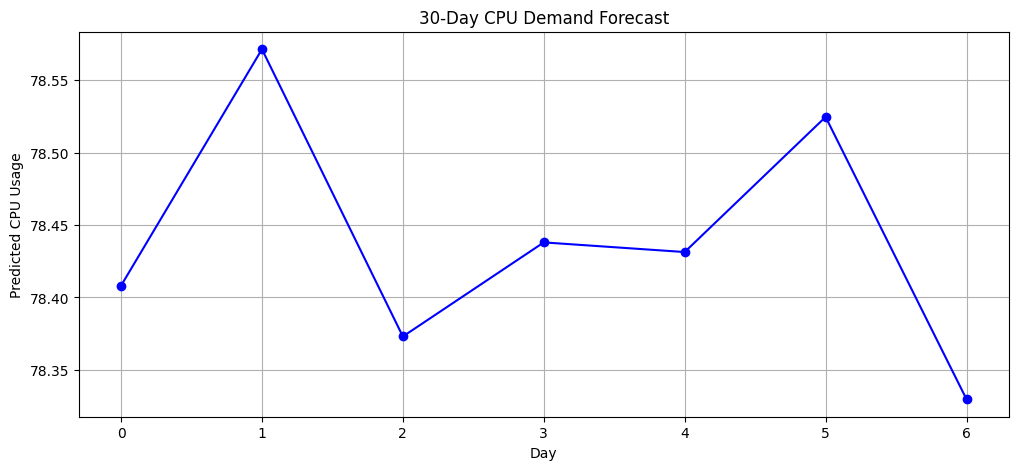

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(future_predictions, marker='o', color='blue')
plt.title("30-Day CPU Demand Forecast")
plt.xlabel("Day")
plt.ylabel("Predicted CPU Usage")
plt.grid(True)
plt.show()


**30 days forecast**

In [ ]:
df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')

model = joblib.load("cpu_demand_model.pkl")
X = df.drop("usage_cpu", axis=1)
feature_cols = X.columns.tolist()


In [ ]:
import pandas as pd
import joblib
import numpy as np


df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')

model = joblib.load("cpu_demand_model.pkl")

X = df.drop("usage_cpu", axis=1)
feature_cols = X.columns.tolist()

history = df.copy()
future_predictions = []

for i in range(30):

    last = history.iloc[-1].copy()
    new_row = {}

    for col in feature_cols:


        if col == "usage_cpu_lag_1":
            new_row[col] = last["usage_cpu"]

        elif col == "usage_cpu_lag_3":
            new_row[col] = history["usage_cpu"].iloc[-3]

        elif col == "usage_cpu_lag_7":
            new_row[col] = history["usage_cpu"].iloc[-7]


        elif col == "usage_cpu_rolling_mean_3":
            new_row[col] = history["usage_cpu"].iloc[-3:].mean()

        elif col == "usage_cpu_rolling_mean_7":
            new_row[col] = history["usage_cpu"].iloc[-7:].mean()


        elif col == "usage_cpu_rolling_std_3":
            new_row[col] = history["usage_cpu"].iloc[-3:].std()

        elif col == "usage_cpu_rolling_std_7":
            new_row[col] = history["usage_cpu"].iloc[-7:].std()


        elif col == "usage_storage_lag_1":
            new_row[col] = last["usage_storage"]

        elif col == "usage_storage_lag_3":
            new_row[col] = history["usage_storage"].iloc[-3]

        elif col == "usage_storage_lag_7":
            new_row[col] = history["usage_storage"].iloc[-7]


        elif col == "usage_storage_rolling_mean_3":
            new_row[col] = history["usage_storage"].iloc[-3:].mean()

        elif col == "usage_storage_rolling_mean_7":
            new_row[col] = history["usage_storage"].iloc[-7:].mean()


        elif col == "users_active_lag_1":
            new_row[col] = last["users_active"]

        elif col == "users_active_lag_3":
            new_row[col] = history["users_active"].iloc[-3]

        elif col == "users_active_lag_7":
            new_row[col] = history["users_active"].iloc[-7]


        elif col == "users_active_rolling_mean_3":
            new_row[col] = history["users_active"].iloc[-3:].mean()

        elif col == "users_active_rolling_mean_7":
            new_row[col] = history["users_active"].iloc[-7:].mean()


        elif col == "users_active_rolling_std_3":
            new_row[col] = history["users_active"].iloc[-3:].std()

        elif col == "users_active_rolling_std_7":
            new_row[col] = history["users_active"].iloc[-7:].std()


        else:
            new_row[col] = last[col]


    new_df = pd.DataFrame([new_row])[feature_cols]


    pred = model.predict(new_df)[0]
    future_predictions.append(pred)


    next_row = last.copy()
    next_row["usage_cpu"] = pred
    history = pd.concat([history, pd.DataFrame([next_row])], ignore_index=True)

future_predictions = [float(x) for x in future_predictions]

print("Next 30-Day CPU Forecast:")
print(future_predictions)




Next 30-Day CPU Forecast:
[78.32594444444445, 78.52959259259259, 78.37333333333333, 78.28966666666668, 78.325, 78.593, 78.358, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334, 78.36633333333334]


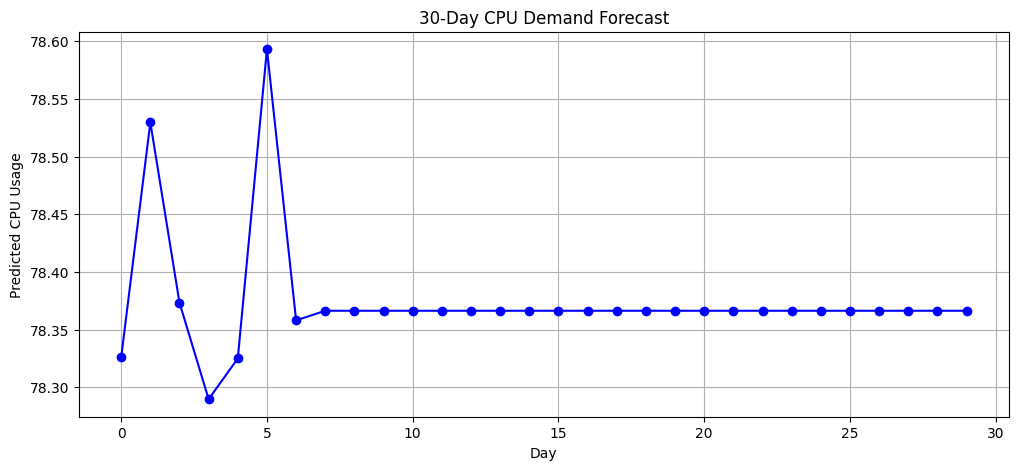

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(future_predictions, marker='o', color='blue')
plt.title("30-Day CPU Demand Forecast")
plt.xlabel("Day")
plt.ylabel("Predicted CPU Usage")
plt.grid(True)
plt.show()


# **New section**

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')

series = df['usage_storage']

model = ARIMA(series, order=(2,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=14)

forecast


,predicted_mean
1080,1239.925924
1081,1242.585790
1082,1242.235712
1083,1242.262855
1084,1242.258653
1085,1242.258909
1086,1242.258856
1087,1242.258858
1088,1242.258858
1089,1242.258858


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]


model = ARIMA(train, order=(2,1,1))
model_fit = model.fit()


predictions = model_fit.forecast(steps=len(test))

mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100   # ← MAPE added here


print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")


MAE: 332.58289078569175
RMSE: 393.07889620909873
MAPE: 31.235031928593077 %


In [ ]:
future_forecast = model_fit.forecast(steps=14)
print("\nNext 14-day forecast:")
print(future_forecast)


Next 14-day forecast:
864    1238.921845
865    1228.107040
866    1237.346477
867    1237.446279
868    1237.669955
869    1237.680975
870    1237.686722
871    1237.687206
872    1237.687362
873    1237.687379
874    1237.687384
875    1237.687384
876    1237.687384
877    1237.687384
Name: predicted_mean, dtype: float64


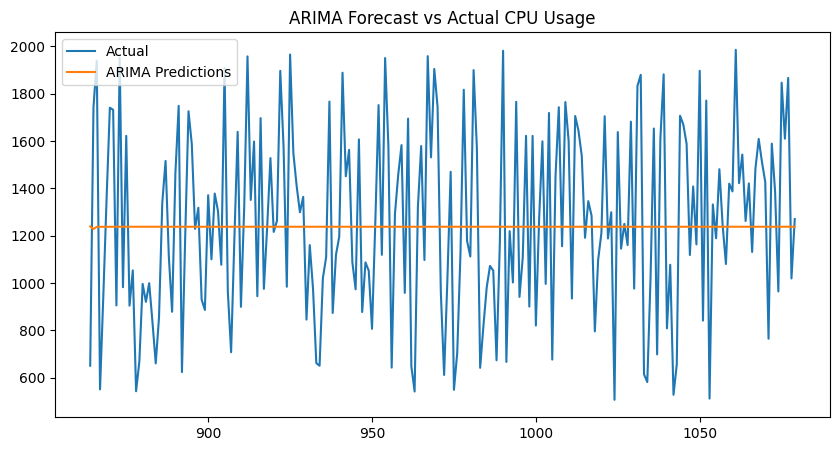

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='ARIMA Predictions')
plt.legend()
plt.title("ARIMA Forecast vs Actual CPU Usage")
plt.show()

random forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')


X = df.drop("usage_storage", axis=1)
y = df["usage_storage"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)
rf.fit(X_train, y_train)


rf_pred = rf.predict(X_test)


rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)


rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

print("Random Forest Results:")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)
print("R²:", rf_r2)
print("MAPE:", rf_mape, "%")


Random Forest Results:
MAE: 40.3131584699162
RMSE: 58.212927391823534
R²: 0.981911445794343
MAPE: 3.3796153428777815 %


xgboost

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Evaluation
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100
print("XGBoost Results:")
print("MAE:", xgb_mae)
print("RMSE:", xgb_rmse)
print("R²:", xgb_r2)
print("Mape:", xgb_mape,"%")


XGBoost Results:
MAE: 35.35364532470703
RMSE: 46.89057553729481
R²: 0.9882635474205017
Mape: 3.3796153428777815 %


In [ ]:
import joblib
joblib.dump(xgb, "cpu__model1.pkl")
print("Model saved successfully!")

Model saved successfully!


ltsm

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np


from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)


X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])


split = int(len(X_scaled) * 0.8)
X_train_lstm, X_test_lstm = X_scaled[:split], X_scaled[split:]
y_train_lstm, y_test_lstm = y[:split], y[split:]


model = Sequential([
    LSTM(64, activation='tanh', input_shape=(1, X_train_lstm.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20, batch_size=32,
    validation_split=0.1,
    verbose=1
)

lstm_pred = model.predict(X_test_lstm).flatten()


lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_pred))
lstm_r2 = r2_score(y_test_lstm, lstm_pred)
lstm_mape= np.mean(np.abs((y_test_lstm - lstm_pred) / y_test_lstm)) * 100
print("LSTM Results:")
print("MAE:", lstm_mae)
print("RMSE:", lstm_rmse)
print("R²:", lstm_r2)
print("Mape:", lstm_mape,"%")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,713 (108.25 KB)

 Trainable params: 27,713 (108.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1734702.5000 - val_loss: 1829216.7500
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1669763.1250 - val_loss: 1821746.0000
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1655033.0000 - val_loss: 1812891.3750
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1665456.7500 - val_loss: 1804939.3750
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1685225.5000 - val_loss: 1798312.8750
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1651563.5000 - val_loss: 1792634.1250
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1637240.5000 - val_loss: 1787563.6250
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1641348.3750 - val_loss: 1782870.7500
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1648271.3750 - val_loss: 1778497.6250
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1701671.8750 - val_loss: 1774283.0000
Epoch 11/20
25/25 ━━━━━━━━━━━━

7 days forecast

In [ ]:
import joblib
import pandas as pd

model = joblib.load("cpu__model1.pkl")
df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')


X = df.drop("usage_storage", axis=1)


sample = X.iloc[[10]]
prediction = model.predict(sample)

print("Predicted storage usage:", prediction[0])
print("Actual storage usage:", df['usage_storage'].iloc[10])


Predicted storage usage: 557.04474
Actual storage usage: 535


In [ ]:
import pandas as pd
import joblib

df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')

model = joblib.load("cpu__model1.pkl")

X = df.drop("usage_storage", axis=1)
feature_cols = X.columns.tolist()

history = df.copy()
future_predictions = []


In [ ]:
  for i in range(7):

      last = history.iloc[-1].copy()
      new_row = {}

      for col in feature_cols:


          if col == "usage_cpu_lag_1":
              new_row[col] = last["usage_cpu"]

          elif col == "usage_cpu_lag_3":
              new_row[col] = history["usage_cpu"].iloc[-3]

          elif col == "usage_cpu_lag_7":
              new_row[col] = history["usage_cpu"].iloc[-7]


          elif col == "usage_cpu_rolling_mean_3":
              new_row[col] = history["usage_cpu"].iloc[-3:].mean()

          elif col == "usage_cpu_rolling_mean_7":
              new_row[col] = history["usage_cpu"].iloc[-7:].mean()

          elif col == "usage_cpu_rolling_std_3":
              new_row[col] = history["usage_cpu"].iloc[-3:].std()

          elif col == "usage_cpu_rolling_std_7":
              new_row[col] = history["usage_cpu"].iloc[-7:].std()

          elif "lag_" in col or "rolling_" in col:

              new_row[col] = last[col]


          else:
              new_row[col] = last[col]


      new_df = pd.DataFrame([new_row])[feature_cols]


      pred = model.predict(new_df)[0]
      future_predictions.append(pred)


      next_row = last.copy()
      next_row["usage_cpu"] = pred
      history = pd.concat([history, pd.DataFrame([next_row])], ignore_index=True)
  future_predictions = [float(x) for x in future_predictions]

  print("Next 7-Day CPU Forecast:")
  print(future_predictions)


Next 7-Day CPU Forecast:
[1274.37109375, 1532.3558349609375, 1541.6915283203125, 1536.4742431640625, 1528.6220703125, 1528.6253662109375, 1528.605224609375]


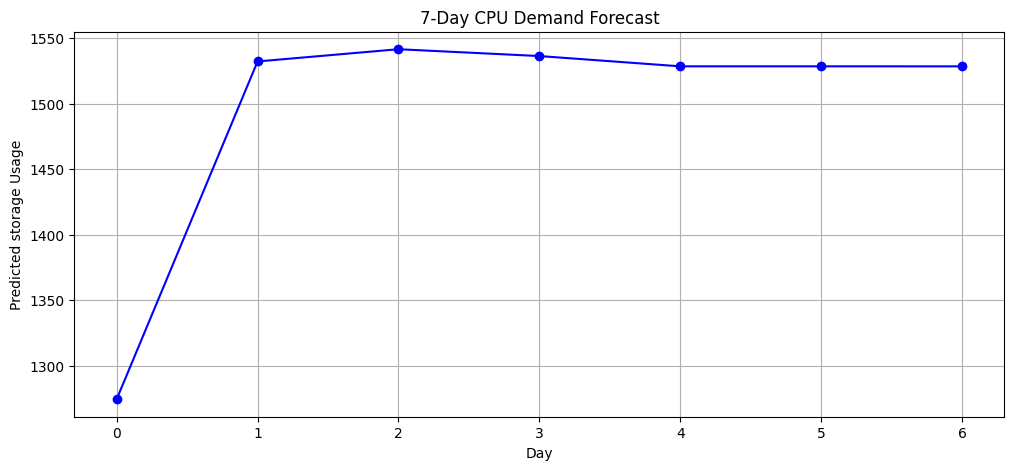

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(future_predictions, marker='o', color='blue')
plt.title("7-Day CPU Demand Forecast")
plt.xlabel("Day")
plt.ylabel("Predicted storage Usage")
plt.grid(True)
plt.show()


30 days forecast

In [ ]:
import pandas as pd
import joblib
import numpy as np


df = pd.read_csv('../data/feature_engineered/mlmodeltrainingdataset.csv')

model = joblib.load("cpu__model1.pkl")

X = df.drop("usage_storage", axis=1)
feature_cols = X.columns.tolist()

history = df.copy()
future_predictions = []

for i in range(30):

    last = history.iloc[-1].copy()
    new_row = {}

    for col in feature_cols:


        if col == "usage_cpu_lag_1":
            new_row[col] = last["usage_storage"]

        elif col == "usage_cpu_lag_3":
            new_row[col] = history["usage_storage"].iloc[-3]

        elif col == "usage_cpu_lag_7":
            new_row[col] = history["usage_storage"].iloc[-7]


        elif col == "usage_cpu_rolling_mean_3":
            new_row[col] = history["usage_storage"].iloc[-3:].mean()

        elif col == "usage_cpu_rolling_mean_7":
            new_row[col] = history["usage_storage"].iloc[-7:].mean()


        elif col == "usage_cpu_rolling_std_3":
            new_row[col] = history["usage_storage"].iloc[-3:].std()

        elif col == "usage_cpu_rolling_std_7":
            new_row[col] = history["usage_storage"].iloc[-7:].std()


        elif col == "usage_storage_lag_1":
            new_row[col] = last["usage_storage"]

        elif col == "usage_storage_lag_3":
            new_row[col] = history["usage_storage"].iloc[-3]

        elif col == "usage_storage_lag_7":
            new_row[col] = history["usage_storage"].iloc[-7]


        elif col == "usage_storage_rolling_mean_3":
            new_row[col] = history["usage_storage"].iloc[-3:].mean()

        elif col == "usage_storage_rolling_mean_7":
            new_row[col] = history["usage_storage"].iloc[-7:].mean()


        elif col == "users_active_lag_1":
            new_row[col] = last["users_active"]

        elif col == "users_active_lag_3":
            new_row[col] = history["users_active"].iloc[-3]

        elif col == "users_active_lag_7":
            new_row[col] = history["users_active"].iloc[-7]


        elif col == "users_active_rolling_mean_3":
            new_row[col] = history["users_active"].iloc[-3:].mean()

        elif col == "users_active_rolling_mean_7":
            new_row[col] = history["users_active"].iloc[-7:].mean()


        elif col == "users_active_rolling_std_3":
            new_row[col] = history["users_active"].iloc[-3:].std()

        elif col == "users_active_rolling_std_7":
            new_row[col] = history["users_active"].iloc[-7:].std()


        else:
            new_row[col] = last[col]


    new_df = pd.DataFrame([new_row])[feature_cols]


    pred = model.predict(new_df)[0]
    future_predictions.append(pred)


    next_row = last.copy()
    next_row["usage_storage"] = pred
    history = pd.concat([history, pd.DataFrame([next_row])], ignore_index=True)

future_predictions = [float(x) for x in future_predictions]

print("Next 30-Day CPU Forecast:")
print(future_predictions)




Next 30-Day CPU Forecast:
[1311.389892578125, 1318.82470703125, 1317.16162109375, 1305.17724609375, 1312.943359375, 1313.2904052734375, 1308.6651611328125, 1308.624755859375, 1308.624755859375, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875, 1308.6375732421875]


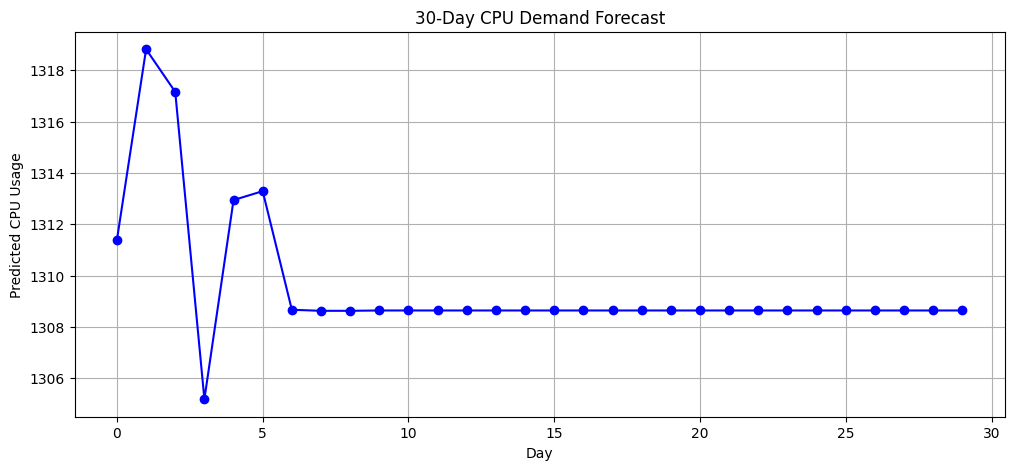

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(future_predictions, marker='o', color='blue')
plt.title("30-Day CPU Demand Forecast")
plt.xlabel("Day")
plt.ylabel("Predicted CPU Usage")
plt.grid(True)
plt.show()
